                             datetime platform  \
count                          263459   263459   
unique                         261204        4   
top     Mon, 24 Apr 2023 21:59:25 GMT      web   
freq                                3   236301   

                                               user_agent  \
count                                              263459   
unique                                                 32   
top     Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...   
freq                                                13623   

                                    visit_id  
count                                 263459  
unique                                146085  
top     cda0796e-3d55-455d-bdb7-c6af96cc5a0e  
freq                                       4  
                             datetime               email platform  \
count                           21836               21836    21836   
unique                          21821               20868        3  

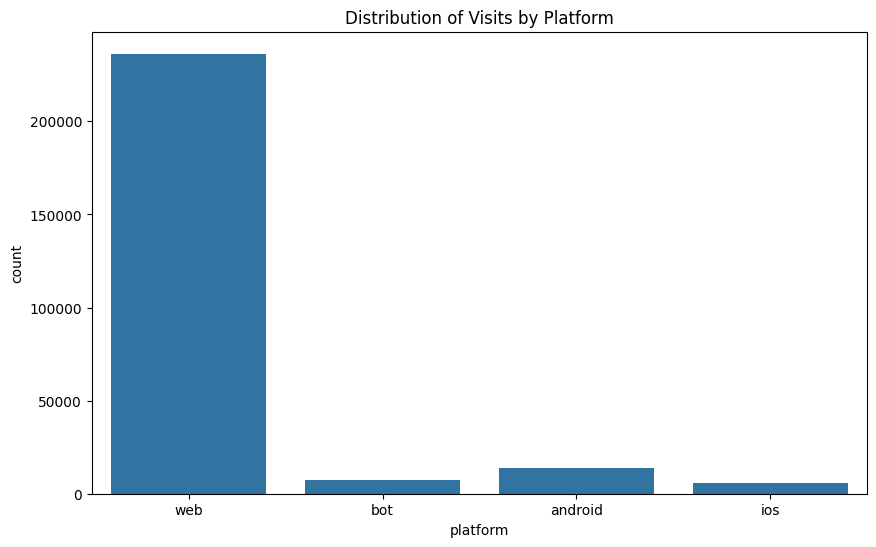

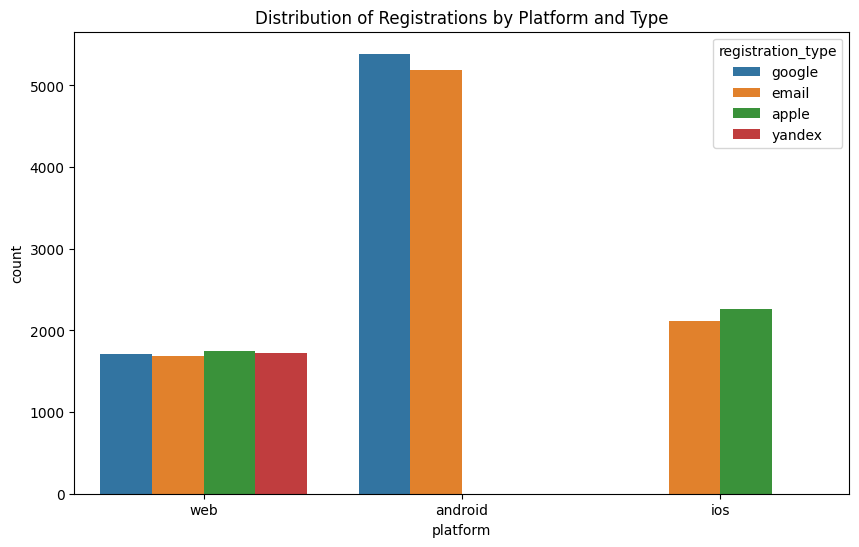

[{"date_group":"2023-03-01T00:00:00.000","platform":"android","visits":75,"registrations":61,"conversion":81.3333333333,"cost":212.0,"utm_campaign":"advanced_algorithms_series"},{"date_group":"2023-03-01T00:00:00.000","platform":"ios","visits":22,"registrations":18,"conversion":81.8181818182,"cost":212.0,"utm_campaign":"advanced_algorithms_series"},{"date_group":"2023-03-01T00:00:00.000","platform":"web","visits":844,"registrations":8,"conversion":0.9478672986,"cost":212.0,"utm_campaign":"advanced_algorithms_series"},{"date_group":"2023-03-02T00:00:00.000","platform":"android","visits":67,"registrations":59,"conversion":88.0597014925,"cost":252.0,"utm_campaign":"advanced_algorithms_series"},{"date_group":"2023-03-02T00:00:00.000","platform":"ios","visits":31,"registrations":24,"conversion":77.4193548387,"cost":252.0,"utm_campaign":"advanced_algorithms_series"},{"date_group":"2023-03-02T00:00:00.000","platform":"web","visits":1128,"registrations":23,"conversion":2.0390070922,"cost":252.

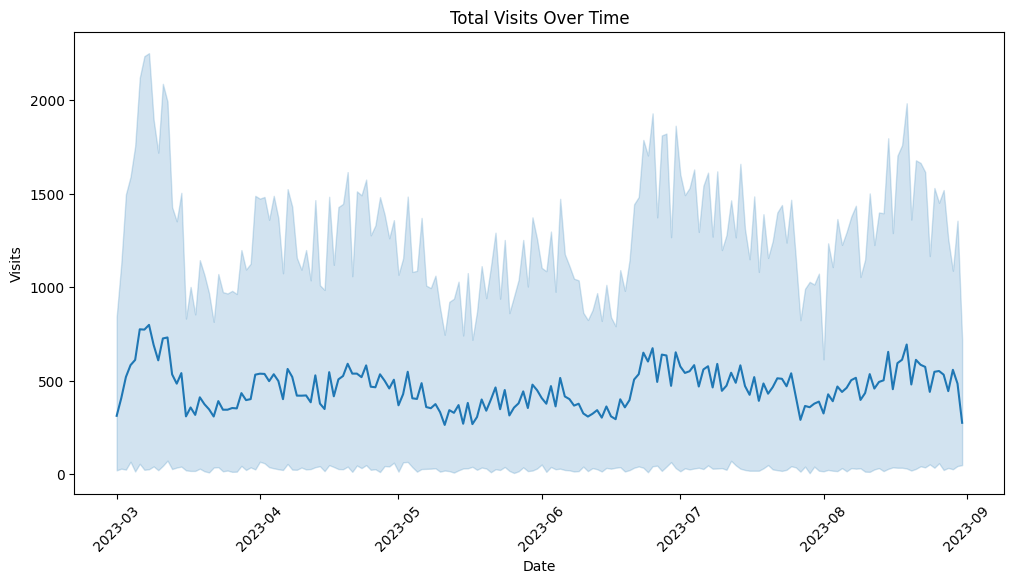

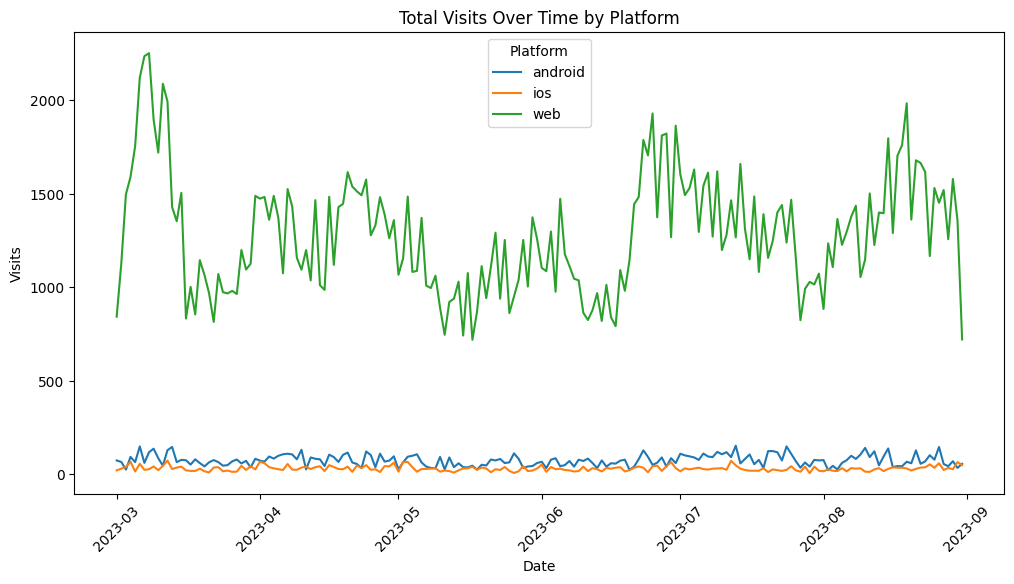

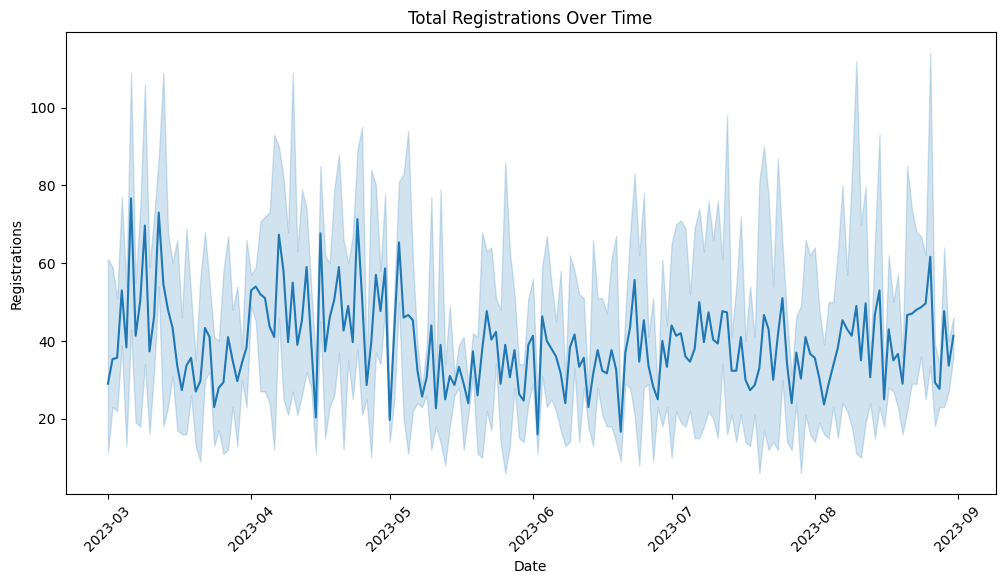

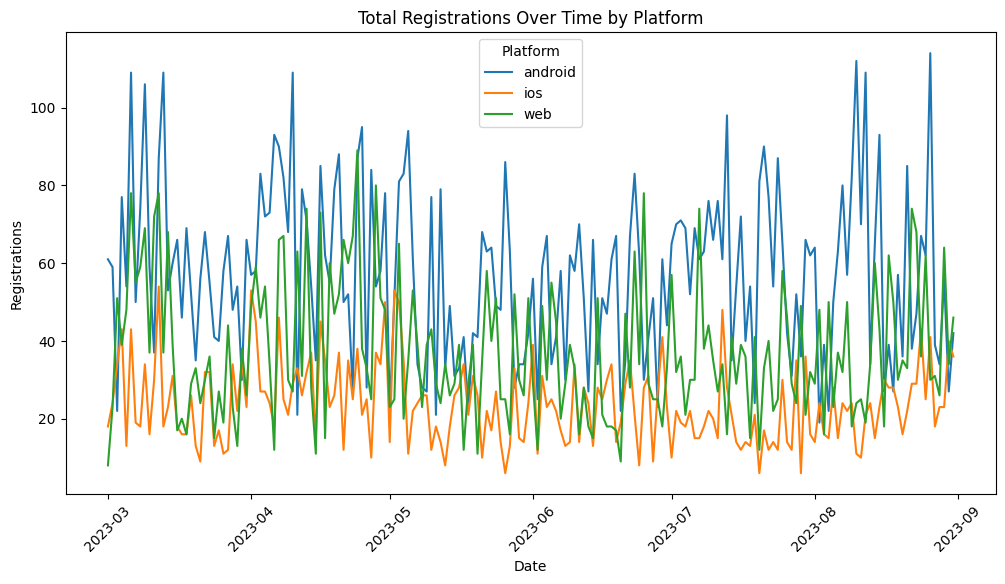

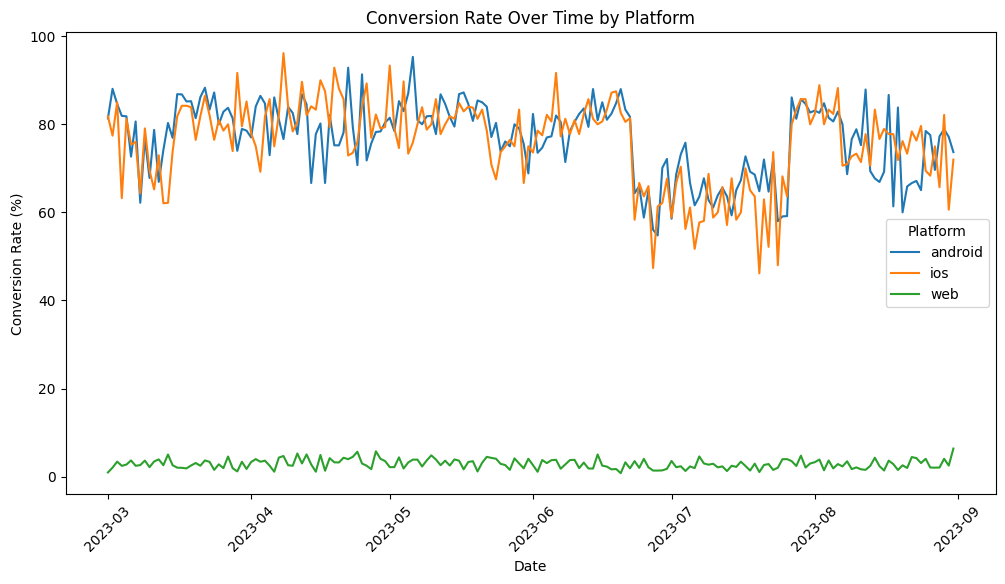

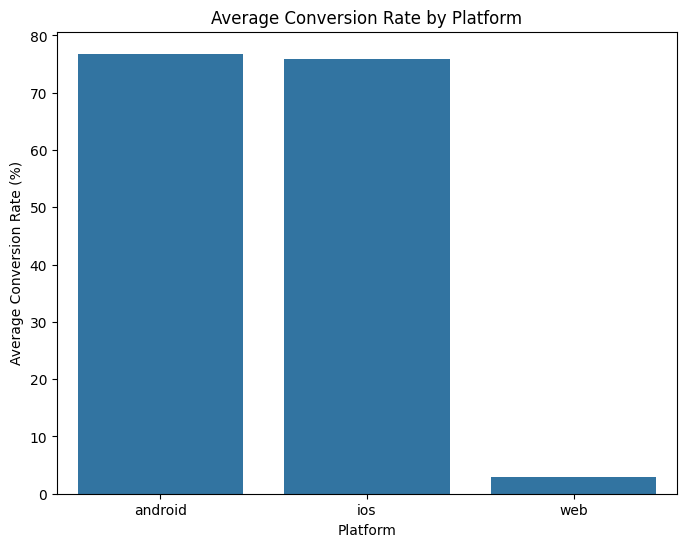

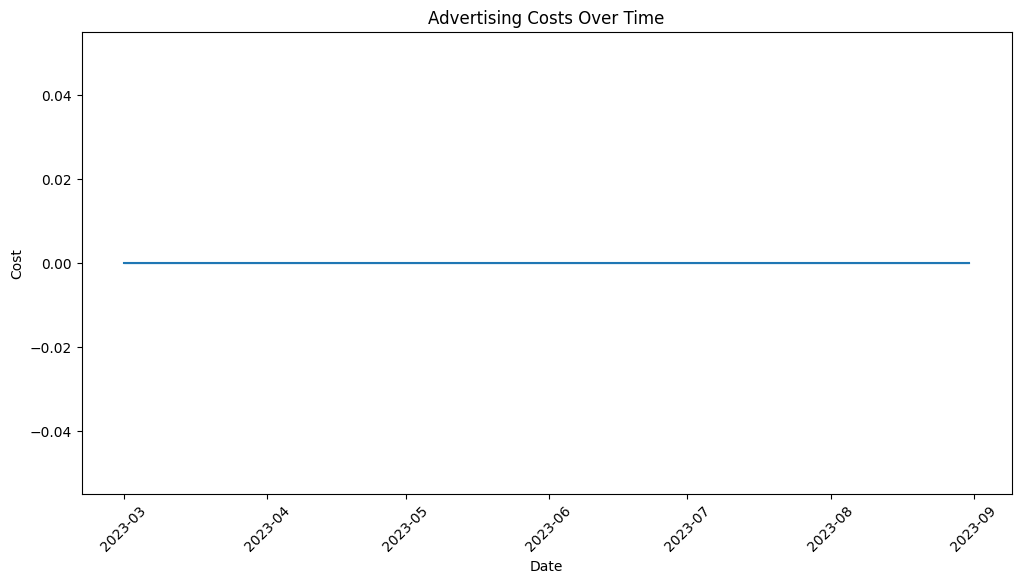

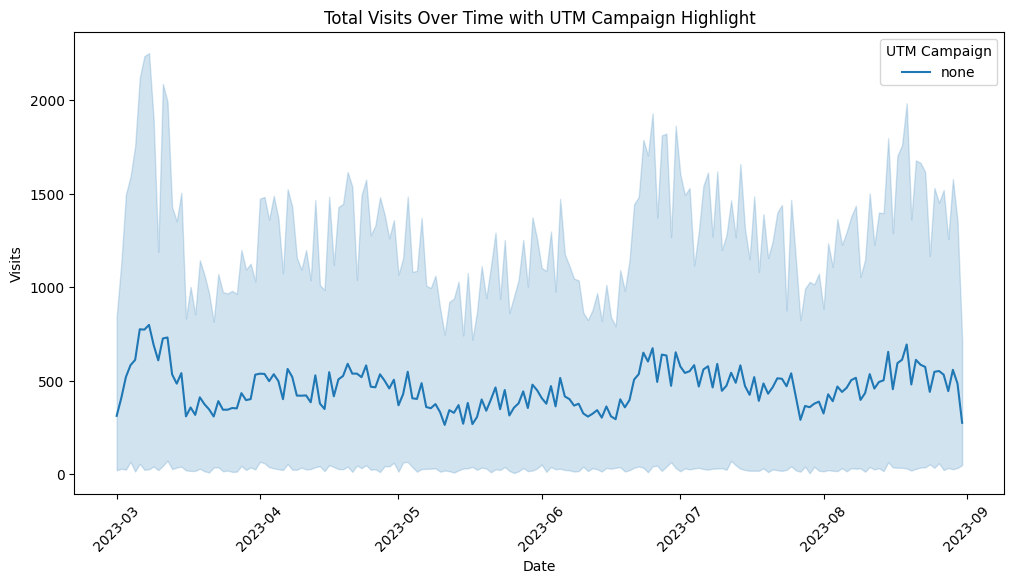

Chart saved: advertising_costs.png
Chart saved: average_conversion_rate.png
Chart saved: conversion_rate_by_platform.png
Chart saved: total_registrations.png
Chart saved: total_registrations_by_platform.png
Chart saved: total_visits.png
Chart saved: total_visits_by_platform.png
Chart saved: utm_campaign.png
JSON file created: ./conversion.json
JSON file created: ./ads.json


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
#import os
from dotenv import load_dotenv

load_dotenv()

# Fetching visits and registrations data
def fetch_visits(api_url, start_date, end_date):
    try:
        response = requests.get(f"{api_url}/visits", params={'begin': start_date, 'end': end_date})
        response.raise_for_status()
        return response.json()
    except requests.exceptions.HTTPError as err:
        print(f"HTTP error occurred: {err}")
        return None
    except Exception as err:
        print(f"Other error occurred: {err}")
        return None

def fetch_registrations(api_url, start_date, end_date):
    try:
        response = requests.get(f"{api_url}/registrations", params={'begin': start_date, 'end': end_date})
        response.raise_for_status()
        return response.json()
    except requests.exceptions.HTTPError as err:
        print(f"HTTP error occurred: {err}")
        return None
    except Exception as err:
        print(f"Other error occurred: {err}")
        return None

api_url = os.getenv("API_URL")
start_date = os.getenv("START_DATE")
end_date = os.getenv("END_DATE")

visits_data = fetch_visits(api_url, start_date, end_date)
registrations_data = fetch_registrations(api_url, start_date, end_date)

if visits_data is None or registrations_data is None:
    print("Failed to fetch data. Exiting.")
    exit(1)

# Converting data to DataFrame
visits_df = pd.DataFrame(visits_data)
registrations_df = pd.DataFrame(registrations_data)

# Initial data analysis
print(visits_df.describe())
print(registrations_df.describe())
print(visits_df.head())
print(registrations_df.head())

# Visualization of visits by platform
plt.figure(figsize=(10, 6))
sns.countplot(x='platform', data=visits_df)
plt.title('Distribution of Visits by Platform')
plt.show()

# Visualization of registrations by platform and type
plt.figure(figsize=(10, 6))
sns.countplot(x='platform', hue='registration_type', data=registrations_df)
plt.title('Distribution of Registrations by Platform and Type')
plt.show()

# Removing bot visits
visits_df = visits_df[~visits_df['user_agent'].str.contains('bot')]

# Converting datetime columns to datetime type
visits_df['datetime'] = pd.to_datetime(visits_df['datetime'])
registrations_df['datetime'] = pd.to_datetime(registrations_df['datetime'])

# Adding date_group column
visits_df['date_group'] = visits_df['datetime'].dt.date
registrations_df['date_group'] = registrations_df['datetime'].dt.date

# Aggregating visits and registrations data
visits_agg = visits_df.groupby(['date_group', 'platform']).size().reset_index(name='visits')
registrations_agg = registrations_df.groupby(['date_group', 'platform']).size().reset_index(name='registrations')

# Merging visits and registrations data
merged_df = pd.merge(visits_agg, registrations_agg, on=['date_group', 'platform'], how='left')
merged_df['registrations'] = merged_df['registrations'].fillna(0)

# Calculating conversion rate
merged_df['conversion'] = (merged_df['registrations'] / merged_df['visits']) * 100
merged_df = merged_df.sort_values(by='date_group')

# Ensuring the directory for charts exists
os.makedirs('./charts', exist_ok=True)
merged_df.to_json('./conversion.json', orient='records', date_format='iso')

# Loading ads data from CSV
ads_df = pd.read_csv('ads.csv')
ads_df['date'] = pd.to_datetime(ads_df['date']).dt.date
ads_agg = ads_df.groupby('date').agg({'cost': 'sum', 'utm_campaign': 'first'}).reset_index()
ads_agg = ads_agg.rename(columns={'date': 'date_group'})
ads_agg['utm_campaign'] = ads_agg['utm_campaign'].fillna('none')

# Merging all data
final_df = pd.merge(merged_df, ads_agg, on='date_group', how='left')
final_df['cost'] = final_df['cost'].fillna(0)
final_df['utm_campaign'] = final_df['utm_campaign'].fillna('none')
final_df.to_json('./ads.json', orient='records', date_format='iso')

# Verifying file creation
with open('./ads.json', 'r') as f:
    data = f.read()
    print(data[:1000])

# Function to prepare data
def prepare_data():
    conversion_df = pd.read_json('./conversion.json')
    ads_df = pd.read_csv('ads.csv')
    
    ads_df['date'] = pd.to_datetime(ads_df['date'])
    conversion_df['date_group'] = pd.to_datetime(conversion_df['date_group'])
    
    ads_grouped = ads_df.groupby('date').agg({'cost': 'sum', 'utm_campaign': 'first'}).reset_index()
    final_df = pd.merge(conversion_df, ads_grouped, left_on='date_group', right_on='date', how='left')
    
    final_df['cost'] = final_df['cost'].fillna(0)
    final_df['utm_campaign'] = final_df['utm_campaign'].fillna('none')
    
    return final_df

# Creating directory for charts
os.makedirs('./charts', exist_ok=True)

# Preparing data
final_df = prepare_data()

# Plotting charts

# Total visits over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x='date_group', y='visits')
plt.title('Total Visits Over Time')
plt.xlabel('Date')
plt.ylabel('Visits')
plt.xticks(rotation=45)
plt.savefig('./charts/total_visits.png')
plt.show()

# Total visits by platform
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x='date_group', y='visits', hue='platform')
plt.title('Total Visits Over Time by Platform')
plt.xlabel('Date')
plt.ylabel('Visits')
plt.xticks(rotation=45)
plt.legend(title='Platform')
plt.savefig('./charts/total_visits_by_platform.png')
plt.show()

# Total registrations over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x='date_group', y='registrations')
plt.title('Total Registrations Over Time')
plt.xlabel('Date')
plt.ylabel('Registrations')
plt.xticks(rotation=45)
plt.savefig('./charts/total_registrations.png')
plt.show()

# Total registrations by platform
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x='date_group', y='registrations', hue='platform')
plt.title('Total Registrations Over Time by Platform')
plt.xlabel('Date')
plt.ylabel('Registrations')
plt.xticks(rotation=45)
plt.legend(title='Platform')
plt.savefig('./charts/total_registrations_by_platform.png')
plt.show()

# Conversion rate by platform
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x='date_group', y='conversion', hue='platform')
plt.title('Conversion Rate Over Time by Platform')
plt.xlabel('Date')
plt.ylabel('Conversion Rate (%)')
plt.xticks(rotation=45)
plt.legend(title='Platform')
plt.savefig('./charts/conversion_rate_by_platform.png')
plt.show()

# Average conversion rate by platform
average_conversion = final_df.groupby('platform')['conversion'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=average_conversion, x='platform', y='conversion')
plt.title('Average Conversion Rate by Platform')
plt.xlabel('Platform')
plt.ylabel('Average Conversion Rate (%)')
plt.savefig('./charts/average_conversion_rate.png')
plt.show()

# Advertising costs over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x='date_group', y='cost')
plt.title('Advertising Costs Over Time')
plt.xlabel('Date')
plt.ylabel('Cost')
plt.xticks(rotation=45)
plt.savefig('./charts/advertising_costs.png')
plt.show()

# Total visits with UTM campaign highlight
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x='date_group', y='visits', hue='utm_campaign')
plt.title('Total Visits Over Time with UTM Campaign Highlight')
plt.xlabel('Date')
plt.ylabel('Visits')
plt.xticks(rotation=45)
plt.legend(title='UTM Campaign')
plt.savefig('./charts/utm_campaign.png')
plt.show()

# Verifying charts
for chart in os.listdir('./charts'):
    if chart.endswith('.png'):
        print(f"Chart saved: {chart}")

# Verify JSON files creation
for file in ['./conversion.json', './ads.json']:
    if os.path.exists(file):
        print(f"JSON file created: {file}")
    else:
        print(f"JSON file not found: {file}")
